# __Complaints against the Chicago Police Department__

The newly-launched Citizens Police Data Project has collected more than 56,000 allegations of police misconduct.

The data, covering 2002-2008 and 2011-2015, includes demographic information about the complainant and the officer, as well as the type and location of the incident. 

[More information on the data is available here.](http://how.cpdp.works/en/articles/1889786-where-does-the-data-come-from-who-is-doing-this-and-why)__

Police violence has been a hot topic in the US for decades. We have seen data on the disproportionate level of violence aimed at black people, as well as the effects of overpolicing on communities of color. But what effect does objecting to this violence achieve? Here we have data on allegations aimed at the police, which include everything from violent abuse of authority, to intoxication, to traffic violations. These complaints and the ensuing investigations are important in understanding the cycle of police brutality in the US.

What we want to know about this data is, What is the percentage of allegations that result in findings or discipline? How many allegations are sustained? And which members of the police are more likely get an allegation on their record?

__Is there any significant difference between the population of the police on who will sustain an allegation?__

Towards the end of this workbook, I will show what statistics I use, and in what sequence, to test my hypotheses.

By looking closely at this data and drawing statistically sound conclusions, we can speak with more authority on the issue of police brutality in Chicago.

<hr>

## Imports

In [214]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import math
import datetime as dt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import Image
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import qgrid
import seaborn as sns
import plotly as py
from plotly.figure_factory import create_violin
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode,iplot
import cufflinks as cf
from plotly.tools import FigureFactory as FF
x = !pwd

The most pertinent data in the dataset comes from the master database, which has aggregated data from the complaintants as well as codes and "edits," which are lamence terms that explain the codes. 

I decided not to use the demographic data related to the complaints. This dataset includes the race and age of the complaintant, but it was not in the scope of this project.

In [215]:
location = 'master-database-values.csv'
officer = 'officer_info.csv'
master = 'Master Database 12-7-15 vF.xlsx'

df = pd.read_csv(location)
officer = pd.read_csv(officer)
complaints = pd.read_excel(master, sheet_name="Complainants")

/Users/dean/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.



In [216]:
complaints.head()

,cwit_id,crid,gender,age,race,race_edit,final_outcome_highest
0,1,1043909,F,24.016438,BLACK,Black,not-sustained
1,2,1043921,F,40.783562,WHITE HISPANIC,White/Hispanic,unknown
2,3,1043926,F,31.978082,BLACK,Black,not-sustained
3,4,1043927,F,53.712329,WHITE,White,not-sustained
4,5,1043930,F,34.287671,BLACK,Black,not-sustained


In [217]:
df.head()

,id,crid,officer_id,cat_id,category,allegation_name,recc_finding,recc_outcome,final_finding,final_outcome,finding_edit,result,outcome_edit,value,beat,location,add1,add2,city,incident_date,start_date,end_date,investigator_id,final_outcome_class
0,1,280573,2104.0,03D,First Amendment and Illegal Arrest,Illegal Arrest / False Arrest,NaN,NaN,NS,600.0,Not Sustained,Unsustained,Unsustained,0,NaN,NaN,NaN,NaN,NaN,NaN,37390.0,37559.0,NaN,not-sustained
1,2,281329,2104.0,05D,Arrest/Lock-up Procedures,Excessive Force / Off Duty - No Injury,NaN,NaN,UN,600.0,Unfounded,Unsustained,Unsustained,0,NaN,NaN,NaN,NaN,NaN,NaN,37415.0,37991.0,NaN,not-sustained
2,3,285275,2104.0,03D,First Amendment and Illegal Arrest,Illegal Arrest / False Arrest,NaN,NaN,EX,600.0,Exonerated,Unsustained,Unsustained,0,NaN,NaN,NaN,NaN,NaN,NaN,37554.0,37846.0,NaN,not-sustained
3,4,286312,2104.0,03B,First Amendment and Illegal Arrest,Improper Search Of Person,NaN,NaN,EX,600.0,Exonerated,Unsustained,Unsustained,0,NaN,NaN,NaN,NaN,NaN,NaN,37601.0,37742.0,NaN,not-sustained
4,5,286958,2104.0,03C,First Amendment and Illegal Arrest,Search Of Premise Without Warrant,NaN,NaN,UN,600.0,Unfounded,Unsustained,Unsustained,0,NaN,NaN,NaN,NaN,NaN,NaN,37632.0,37799.0,NaN,not-sustained


In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56384 entries, 0 to 56383
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   56384 non-null  int64  
 1   crid                 56384 non-null  object 
 2   officer_id           48314 non-null  float64
 3   cat_id               42779 non-null  object 
 4   category             56384 non-null  object 
 5   allegation_name      56384 non-null  object 
 6   recc_finding         6831 non-null   object 
 7   recc_outcome         16551 non-null  float64
 8   final_finding        33062 non-null  object 
 9   final_outcome        28144 non-null  float64
 10  finding_edit         56384 non-null  object 
 11  result               56384 non-null  object 
 12  outcome_edit         56384 non-null  object 
 13  value                56384 non-null  object 
 14  beat                 27731 non-null  float64
 15  location             28585 non-null 

In [219]:
df.allegation_name.unique()

array(['Illegal Arrest / False Arrest',
       'Excessive Force / Off Duty - No Injury',
       'Improper Search Of Person', 'Search Of Premise Without Warrant',
       'Excessive Force / On Duty - Injury',
       'Unnecessary Display Of Weapon / Off Duty', 'Use Of Profanity',
       'Unnecessary Physical Contact / On Duty - No Injury',
       'Neglect Of Duty', 'Association With Felon', 'Reports',
       'Domestic Incident - Not Physical', 'Prisoners Property',
       'Misuse Of Department Equipment / Supplies', 'Miscellaneous',
       'Excessive Force / On Duty - No Injury', 'Inventory Procedures',
       'Proper Care - Injury / Death', 'Federal Civil Suit',
       'Excessive Force - Use Of Firearm / Off Duty - Injury',
       'Excessive Force - Use Of Firearm / Off Duty - No Injury',
       'Inadequate / Failure To Provide Service',
       'Improper Search Of Vehicle',
       'Unnecessary Display Of Weapon / On Duty',
       'Damage / Trespassing To Property',
       'Domestic Alter

In [220]:
df.dtypes

id                       int64
crid                    object
officer_id             float64
cat_id                  object
category                object
allegation_name         object
recc_finding            object
recc_outcome           float64
final_finding           object
final_outcome          float64
finding_edit            object
result                  object
outcome_edit            object
value                   object
beat                   float64
location                object
add1                   float64
add2                    object
city                    object
incident_date          float64
start_date             float64
end_date               float64
investigator_id        float64
final_outcome_class     object
dtype: object

<hr>

## Data cleaning

Most important (missing) data should be dropped. If we don't know who the officer is, for example, that entire row becomes unusable. Those rows are dropped from the complaints dataframe.

Unusable data is converted to something we recognize. 

Impertinent information is converted to zero, since it is not being used.

<video controls src="https://i.imgur.com/HC0lfRj.mp4" />

In [221]:
df.dropna(subset=['officer_id'], inplace=True)

In [222]:
df['start_date'] = pd.TimedeltaIndex(df['start_date'], unit='d') + dt.datetime(1900,1,1)
df['end_date'] = pd.TimedeltaIndex(df['end_date'], unit='d') + dt.datetime(1900,1,1)
df['incident_date'] = pd.TimedeltaIndex(df['incident_date'], unit='d') + dt.datetime(1900,1,1)

In [223]:
officer['appt_date'] = pd.TimedeltaIndex(officer['appt_date'], unit='d') + dt.datetime(1900,1,1)

### Null Values

I decided not to drop null values that were not pertinent to the key statistics. 

The birth year, unit number and star number have several null values that would take away rows with valuable demographic information re: individual officers. 

In [224]:
print(officer['birth_year'].isnull().sum())
print(officer['unit'].isnull().sum())
print(officer['star'].isnull().sum())

2832
1662
1021


In [225]:
officer['unit'].fillna(0, inplace=True)

In [226]:
officer['birth_year'].fillna(officer['birth_year'].mean(), inplace=True)

Filling the birth year with the mean is not ideal, but lets us keep these important records while being able to run accurate functions.

In [227]:
officer['birth_year'] = officer['birth_year'].apply(np.int64)

In [228]:
df['officer_id'] = df['officer_id'].apply(np.int64)

In [229]:
df = df.set_index('officer_id').join(officer.set_index('officer_id'))

In [230]:
df = df.sort_values('id')

In [231]:
df.columns

Index(['id', 'crid', 'cat_id', 'category', 'allegation_name', 'recc_finding',
       'recc_outcome', 'final_finding', 'final_outcome', 'finding_edit',
       'result', 'outcome_edit', 'value', 'beat', 'location', 'add1', 'add2',
       'city', 'incident_date', 'start_date', 'end_date', 'investigator_id',
       'final_outcome_class', 'officer_name', 'officer_first', 'officer_last',
       'gender', 'race', 'race_edit', 'appt_date', 'star', 'rank', 'unit',
       'birth_year', 'Active (June 1 2015)', 'allegations_count',
       'discipline_count'],
      dtype='object')

## Police Demographics

We start to see some demographic information about the police officers. Some information is unknown, but from the data that is gathered the majority of officers are white, followed closely by black and Hispanic.

In [232]:
df['race_edit'].value_counts()

White             18961
Unknown           12578
Black              8348
Hispanic           7187
Asian               764
White/Hispanic      310
Italian             166
Name: race_edit, dtype: int64

In [233]:
df['gender'].value_counts()

M    31551
F     4185
Name: gender, dtype: int64

### Results of Allegations

Here is important information about the result of the allegation. Anything that is not "sustained" did not result in discipline.

In [234]:
df['finding_edit'].value_counts()

Not Sustained     14422
Unfounded         12999
No Affidavit       9722
Unknown            5530
Exonerated         3305
Sustained          2295
No Cooperation       30
Discharged           11
Name: finding_edit, dtype: int64

In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48314 entries, 2104 to 8195
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    48314 non-null  int64         
 1   crid                  48314 non-null  object        
 2   cat_id                42779 non-null  object        
 3   category              48314 non-null  object        
 4   allegation_name       48314 non-null  object        
 5   recc_finding          6831 non-null   object        
 6   recc_outcome          16551 non-null  float64       
 7   final_finding         33062 non-null  object        
 8   final_outcome         28144 non-null  float64       
 9   finding_edit          48314 non-null  object        
 10  result                48314 non-null  object        
 11  outcome_edit          48314 non-null  object        
 12  value                 48314 non-null  object        
 13  beat          

In [236]:
df.dropna(subset=['final_outcome'], inplace=True)

In [237]:
df['final_outcome'] = df['final_outcome'].apply(np.int64)

In [238]:
df['outcome_edit'].value_counts()

Unsustained                   25856
Reprimand                       603
1                               374
Noted                           243
2                               173
5                               144
Resigned                        134
3                               129
Not Served                       94
30                               68
15                               65
10                               58
Separation                       43
20                               31
4                                19
7                                17
Over 30                          17
25                               14
6                                12
45                                7
60                                7
Administrative Termination        7
Reinstated - Board                5
8                                 4
Unknown                           4
90                                3
12                                3
21                          

In [239]:
officer['unit'] = officer['unit'].apply(np.int64)

In [240]:
df['investigator_id'].fillna(0, inplace=True)

In [241]:
df['investigator_id'] = df['investigator_id'].apply(np.int64)

In [242]:
df['beat'].fillna(0, inplace=True)

In [243]:
df['beat'] = df['beat'].apply(np.int64)

In [244]:
df['add1'].fillna(0, inplace=True)

In [245]:
df['add1'] = df['add1'].apply(np.int64)

In [246]:
df['star'].fillna(0, inplace=True)

In [247]:
df['star'] = df['star'].apply(np.int64)

In [248]:
df.dropna(subset=['final_outcome_class'], inplace=True)

In [249]:
df['unit'].fillna(0, inplace=True)

In [250]:
df['unit'] = df['unit'].apply(np.int64)

In [251]:
df['final_outcome_class'].value_counts()

not-sustained    25858
disciplined       1807
sustained          479
Name: final_outcome_class, dtype: int64

In [252]:
df.reset_index(inplace=True, drop=False)

### First glimpse of data

Here we see the first five rows of data, which show several columns that we are not going to use. The columns can be reduced for readability. 

In [253]:
grid = qgrid.show_grid(df, show_toolbar = True)
grid

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [254]:
df.head(5)

,officer_id,id,crid,cat_id,category,allegation_name,recc_finding,recc_outcome,final_finding,final_outcome,finding_edit,result,outcome_edit,value,beat,location,add1,add2,city,incident_date,start_date,end_date,investigator_id,final_outcome_class,officer_name,officer_first,officer_last,gender,race,race_edit,appt_date,star,rank,unit,birth_year,Active (June 1 2015),allegations_count,discipline_count
0,2104,1,280573,03D,First Amendment and Illegal Arrest,Illegal Arrest / False Arrest,NaN,NaN,NS,600,Not Sustained,Unsustained,Unsustained,0,0,NaN,0,NaN,NaN,NaT,2002-05-16,2002-11-01,0,not-sustained,"DUNDERDALE, CRAIG",CRAIG,DUNDERDALE,NaN,NaN,Unknown,NaT,12346,NaN,193,1969,Unknown,20,0
1,2104,2,281329,05D,Arrest/Lock-up Procedures,Excessive Force / Off Duty - No Injury,NaN,NaN,UN,600,Unfounded,Unsustained,Unsustained,0,0,NaN,0,NaN,NaN,NaT,2002-06-10,2004-01-07,0,not-sustained,"DUNDERDALE, CRAIG",CRAIG,DUNDERDALE,NaN,NaN,Unknown,NaT,12346,NaN,193,1969,Unknown,20,0
2,2104,3,285275,03D,First Amendment and Illegal Arrest,Illegal Arrest / False Arrest,NaN,NaN,EX,600,Exonerated,Unsustained,Unsustained,0,0,NaN,0,NaN,NaN,NaT,2002-10-27,2003-08-15,0,not-sustained,"DUNDERDALE, CRAIG",CRAIG,DUNDERDALE,NaN,NaN,Unknown,NaT,12346,NaN,193,1969,Unknown,20,0
3,2104,4,286312,03B,First Amendment and Illegal Arrest,Improper Search Of Person,NaN,NaN,EX,600,Exonerated,Unsustained,Unsustained,0,0,NaN,0,NaN,NaN,NaT,2002-12-13,2003-05-03,0,not-sustained,"DUNDERDALE, CRAIG",CRAIG,DUNDERDALE,NaN,NaN,Unknown,NaT,12346,NaN,193,1969,Unknown,20,0
4,2104,5,286958,03C,First Amendment and Illegal Arrest,Search Of Premise Without Warrant,NaN,NaN,UN,600,Unfounded,Unsustained,Unsustained,0,0,NaN,0,NaN,NaN,NaT,2003-01-13,2003-06-29,0,not-sustained,"DUNDERDALE, CRAIG",CRAIG,DUNDERDALE,NaN,NaN,Unknown,NaT,12346,NaN,193,1969,Unknown,20,0


## Observations

### Avg. Length of Investigation

The length between the time of the incident and the end of the investigation has a mean of 241 days.

In [255]:
inv_length = (df['end_date'] - df['incident_date'])
inv_length.describe()

count                       16434
mean     241 days 01:28:29.249191
std      258 days 15:36:26.376376
min       11 days 20:24:59.616000
25%       76 days 11:51:30.240000
50%             124 days 00:00:00
75%      302 days 13:02:29.760000
max            1353 days 00:00:00
dtype: object

In [256]:
df.columns

Index(['officer_id', 'id', 'crid', 'cat_id', 'category', 'allegation_name',
       'recc_finding', 'recc_outcome', 'final_finding', 'final_outcome',
       'finding_edit', 'result', 'outcome_edit', 'value', 'beat', 'location',
       'add1', 'add2', 'city', 'incident_date', 'start_date', 'end_date',
       'investigator_id', 'final_outcome_class', 'officer_name',
       'officer_first', 'officer_last', 'gender', 'race', 'race_edit',
       'appt_date', 'star', 'rank', 'unit', 'birth_year',
       'Active (June 1 2015)', 'allegations_count', 'discipline_count'],
      dtype='object')

In [257]:
df['finding_edit'].value_counts()

No Affidavit      9721
Not Sustained     8295
Unfounded         5916
Sustained         2285
Exonerated        1915
No Cooperation       9
Discharged           3
Name: finding_edit, dtype: int64

In [258]:
df['age'] = df['incident_date'].dt.year - df['birth_year']

In [259]:
df['age'].describe()

count    16463.000000
mean        41.373869
std          8.885015
min         22.000000
25%         34.000000
50%         42.000000
75%         45.000000
max         98.000000
Name: age, dtype: float64

### Top 20 Offenders

I wanted to take a look at the officers who had the most allegations against them. These officers are sorted in descending order to show the race and rank of the top 20 officers with most allegations.

In [260]:
sum_df = pd.DataFrame(df.groupby(['officer_id', 'officer_name', 'race_edit', 'rank'])['id'].agg('count'))
sum_df = sum_df.sort_values('id', ascending = False)
sum_df.reset_index(inplace=True, drop=False)
sum_df['allegations_count'] = sum_df['id']
sum_df.drop(columns=['id'], inplace=True)

In [261]:
sum_df.head(20)

,officer_id,officer_name,race_edit,rank,allegations_count
0,6301,"PIWNICKI, RAYMOND",White,DET,64
1,5958,"OSBORN, KEVIN",White,PO,50
2,1471,"CONNOLLY, MICHAEL",White,PO,50
3,7046,"RYAN, KEVIN",White,PO,43
4,8742,"WOJTAN, KENNETH",White,PO,41
5,6391,"PRICE, ALMA",Black,PO,41
6,7906,"TERESI, MARTIN",White,PO,41
7,192,"ANDERSON, MAURICE",Black,PO,40
8,6679,"RICE, BRET",White,DET,40
9,3131,"HALEEM, MAHMOUD",Asian,PO,37


We can see here that, out of the 20 officers with the highest count of allegations, only 4 are black and one is Asian. The rest are white.

In [262]:
df = df[['id', 'officer_id', 'officer_name', 'incident_date', 'birth_year', 'race_edit', 'gender', 'age', 
         'star', 'rank', 'unit', 'crid', 'category', 'allegation_name', 'final_finding', 'finding_edit', 
         'final_outcome', 'add1', 'add2', 'city', 'start_date', 'end_date']]

## Setting up the key statistic 

* The  allegations that were sustained will get a value of 1.
* All others will get a zero.
* The 'sustained' column will be used for the key statistic.

In [263]:
def sustain(row):
    if row['finding_edit'] == 'Sustained':
        return 1
    else:
        return 0

df['sustained'] = df.apply(lambda row: sustain(row), axis=1)

In [264]:
df['sustained'].value_counts()

0    25859
1     2285
Name: sustained, dtype: int64

This is the mean of sustained allegations is the statistic that we will drill down. 

The total rate for sustaining an allegation is 8%. This means that 92% of allegations are unsustained and do not result in discipline.

In [265]:
df['sustained'].mean()

0.08118959636156907

We will begin to look at the allegations based on race and gender of the offender. We can only work with known races, so we will isolate the white, black and hispanic dataframes to take a closer look.

In [266]:
df['race_edit'].value_counts()

White             12093
Black              5418
Unknown            5264
Hispanic           4563
Asian               492
White/Hispanic      223
Italian              91
Name: race_edit, dtype: int64

### Dividing the data

These dataframes will be used to drill into the data further:

In [267]:
sustained = df[(df['sustained'] == 1)]
unsustained = df[(df['sustained'] == 0)]

In [268]:
men = df[(df['gender'] == 'M')]
women =  df[(df['gender'] == 'F')]

In [269]:
white = df[((df['race_edit'] == 'White') | (df['race_edit'] == 'Italian'))]
black = df[(df['race_edit'] == 'Black')]
hispanic = df[((df['race_edit'] == 'White/Hispanic') | (df['race_edit'] == 'Hispanic'))]

In [270]:
police_officer = df[(df['rank'] == 'PO')]
sergeant = df[(df['rank'] == 'SGT')]
detective = df[(df['rank'] == 'DET')]

### Data Inferences

#### Gender

* Women sustain allegations more often than men.

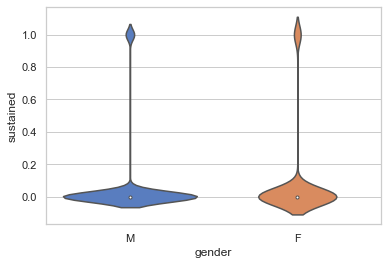

In [271]:
ax = sns.violinplot(x="gender", y="sustained",
                    data=df, palette="muted")

In [272]:
print(men['sustained'].mean())
print(women['sustained'].mean())

0.05982008995502249
0.0794425087108014


* Men in the CPD have a 5.9% mean of sustaining an allegation.
* Women in the CPD have a 7.9% mean of sustaining an allegation.

#### Race

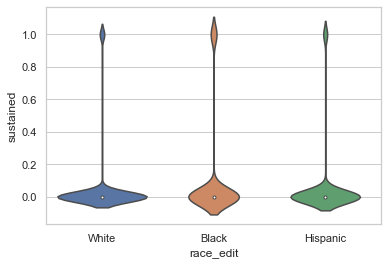

In [295]:
ax = sns.violinplot(x="race_edit", y="sustained", order=["White", "Black", "Hispanic"], data=df)

* White members of the police have a 4.8% chance of an allegation being sustained.

* Black members of the police have a 10.3% chance of an allegation being sustained.

In [274]:
white['sustained'].mean()

0.04842416283650689

In [275]:
black['sustained'].mean()

0.10299003322259136

* Hispanic members of the police have a 5.3% chance of an allegation being sustained.

In [276]:
hispanic['sustained'].mean()

0.05265357292101964

#### Rank

We will also look at a breakdown between rank of police. 

* We see that detectives have a 4.8% chance of an allegation being sustained.

In [277]:
detective['sustained'].mean()

0.04807692307692308

* Police officers have a 6.2% chance of sustaining an allegation.

In [278]:
police_officer['sustained'].mean()

0.062223393045310854

* Sergeants have a 6.5% chance of sustaining an allegation.

In [279]:
sergeant['sustained'].mean()

0.06564056133997284

#### Top Categories

We start to see what sorts of complaints result in the allegation being sustained. Below are the top five allegations sorted by the name of the specific allegation.

The total allegations are include the search of a premise without a warrant and excessive force resulting in injury.

In [280]:
total_sum_df = pd.DataFrame(df.groupby(['allegation_name', 'category'])['id'].agg('count'))
total_sum_df = total_sum_df.sort_values('id', ascending = False)
total_sum_df.reset_index(inplace=True, drop=False)
total_sum_df['count'] = total_sum_df['id']
total_sum_df.drop(columns=['id'], inplace=True)
total_sum_df.head(5)

,allegation_name,category,count
0,Inadequate / Failure To Provide Service,Operation/Personnel Violations,3647
1,Search Of Premise Without Warrant,First Amendment and Illegal Arrest,2888
2,Unknown,Unknown,2879
3,Excessive Force / On Duty - Injury,Arrest/Lock-up Procedures,2330
4,Illegal Arrest / False Arrest,First Amendment and Illegal Arrest,2258


<br>

The sustained allegations are a bit different, mainly in that they don't include excessive force or illegal arrest.

In [281]:
sustained_sum_df = pd.DataFrame(sustained.groupby(['allegation_name', 'category'])['id'].agg('count'))
sustained_sum_df = sustained_sum_df.sort_values('id', ascending = False)
sustained_sum_df.reset_index(inplace=True, drop=False)
sustained_sum_df['count'] = sustained_sum_df['id']
sustained_sum_df.drop(columns=['id'], inplace=True)
sustained_sum_df.head(5)

,allegation_name,category,count
0,Neglect Of Duty,Operation/Personnel Violations,361
1,Miscellaneous,Operation/Personnel Violations,216
2,Unknown,Unknown,112
3,Inadequate / Failure To Provide Service,Operation/Personnel Violations,111
4,Association With Felon,Conduct Unbecoming (Off-duty),99


<hr>

In [282]:
trace1 = go.Bar(
    x=sustained["category"].value_counts().keys().tolist(),
    y=sustained["category"].value_counts().values.tolist() / sustained["category"].value_counts().values.sum(),
    name='sustained'
)
trace2 = go.Bar(
    x=unsustained["category"].value_counts().keys().tolist(),
    y=unsustained["category"].value_counts().values.tolist() / unsustained["category"].value_counts().values.sum(),
    name='unsustained'
)

data = [trace1, trace2]
plotly.offline.iplot({
    "data": data,
    "layout": go.Layout(barmode='group', title="Categories of complaints, % of total"
                           ,width=800,height=600,)
})

#### Age Distributions

In [283]:
# defining data
trace = go.Histogram(x=sustained['age'],nbinsx=40,histnorm='percent')
data = [trace]
# defining layout
layout = go.Layout(title="Age Distribution - Sustained")
# defining figure and plotting
fig = go.Figure(data = data,layout = layout)
iplot(fig)

In [284]:
# defining data
trace = go.Histogram(x=unsustained['age'],nbinsx=40,histnorm='percent')
data = [trace]
# defining layout
layout = go.Layout(title="Age Distribution - Unsustained")
# defining figure and plotting
fig = go.Figure(data = data,layout = layout)
iplot(fig)

## Statistical data

The following data will be tested with statistic methods, using A-B testing.

### Gender

A t-test shows that there is a significant difference between these two sample means:

In [285]:
stats.ttest_ind(men['sustained'], women['sustained'])
# significant difference

Ttest_indResult(statistic=-4.069222881485798, pvalue=4.732845483951708e-05)

### Race

#### Three-group test

To start, we will see what null hypothesis can be rejected using a significance level of 0.05. 

\begin{equation}
Q=\frac{M_i-M_j}{\sqrt{MSE/n}}
\end{equation}

The table below shows which two groups within the population can safely be rejected on the null hypothesis that they do not differ.

In [286]:
tukey = pairwise_tukeyhsd(endog = df['sustained'],      # Data
                          groups = df['race_edit'],   # Groups
                          alpha=0.05)         # Significance level

In [287]:
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Asian,Black,0.0522,0.001,0.0148,0.0896,True
Asian,Hispanic,0.0029,0.9,-0.0348,0.0406,False
Asian,Italian,0.0481,0.68,-0.0426,0.1388,False
Asian,Unknown,0.1126,0.001,0.0751,0.15,True
Asian,White,-0.0028,0.9,-0.0393,0.0338,False
Asian,White/Hispanic,-0.0194,0.9,-0.0836,0.0447,False
Black,Hispanic,-0.0493,0.001,-0.0653,-0.0333,True
Black,Italian,-0.0041,0.9,-0.0881,0.0799,False
Black,Unknown,0.0604,0.001,0.045,0.0758,True
Black,White,-0.0549,0.001,-0.0679,-0.042,True


The ANOVA or F-statistic shows that all three major racial groups vary within the population. We will drill down the biggest differences between groups with t-tests.

\begin{equation}
F=\frac{{n\sum(\bar{Y}_j-\bar{Y})^2}/{(a-1)}}{{\sum\sum(Y_{ij}-\bar{Y}_j)^2}/{(N-a)}}
\end{equation}

In [288]:
stats.f_oneway(white['sustained'], black['sustained'], hispanic['sustained'])

F_onewayResult(statistic=101.19942117328999, pvalue=1.7666621789352633e-44)

#### Two-group test

The t-test shows that the biggest difference is between white and black police members, with a p-value well under 0.05. The p-value is the probability that, given that the null hypothesis  𝐻0  is true, we could have ended up with a statistic at least as extreme as the one we got.

$$t = \frac{\bar{x}_E - \bar{x}_C}{\sqrt {s^2 \Big(\frac{1}{n_E} + \frac{1}{n_C}\Big)}}$$

In [289]:
stats.ttest_ind(white['sustained'], black['sustained'])
# significant difference

Ttest_indResult(statistic=-13.603683269406199, pvalue=6.204719018959907e-42)

The t-test between white and Hispanic police members shows little difference with a p-value of 0.21, falling well above the significance mark of 0.05.

In [290]:
stats.ttest_ind(white['sustained'], hispanic['sustained'])
# not much of a difference, based on p-value

Ttest_indResult(statistic=-1.1416863103349923, pvalue=0.2536005443408599)

The t-test between black and Hispanic police officers shows a significant difference, but the p-value is not as low as between white and black members.

In [291]:
stats.ttest_ind(hispanic['sustained'], black['sustained'])
# significant difference

Ttest_indResult(statistic=-9.426414009077046, pvalue=5.165826519173117e-21)

### Rank

#### Three-group test

The ranks of police members who have sustained an allegation shows no significant difference, according to the high p-value in the ANOVA below. This means that the null hypothesis cannot be rejected.

In [292]:
stats.f_oneway(police_officer['sustained'], sergeant['sustained'], detective['sustained'])

F_onewayResult(statistic=1.645561343101725, pvalue=0.19292797024828692)

I have also run a Kruskal-Wallis test to see if the p-value is concurrent with the ANOVA. The p-value here is still above 0.05, which is our significance level. This agrees with the ANOVA; there is no significant difference between these groups of the population.

In [293]:
stats.kruskal(police_officer['sustained'], sergeant['sustained'], detective['sustained'])

KruskalResult(statistic=3.2909297255708303, pvalue=0.1929228592877275)